In [8]:
import tensorflow as tf
import keras
from keras import layers

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
from pathlib import Path
import pandas as pd
import cv2
import seaborn as sns

from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore

from tensorflow.keras.models import Model 
from tensorflow.python.profiler import profiler_v2 as profiler

In [ ]:
# Configurar a seed do TensorFlow
tf.keras.utils.set_random_seed(42)
# Definir a seed global para a operação de GPU
tf.config.experimental.enable_op_determinism()

# tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

!nvidia-smi # Verifica a GPU
!nvcc --version   # Verifica a versão do CUDA

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Aloca memória dinamicamente
        print("Memória da GPU configurada para crescimento dinâmico.")
    except RuntimeError as e:
        print(e)

tf.config.optimizer.set_jit(True)  # Ativa JIT (Just-in-Time) Compilation
print("XLA ativado.")

## Ler as imagens e divisão em 3 conjuntos

In [9]:
tf.keras.utils.set_random_seed(777)
tf.config.experimental.enable_op_determinism()

img_height = 256
img_width = 256

path = Path("data") 

train_ds = keras.utils.image_dataset_from_directory(
    path,
    label_mode="binary",
    class_names=["Interior", "Exterior"],  # pode ser omitido se quiser detectar automaticamente
    image_size=(img_height, img_width),
    seed=777,
    validation_split=0.3,  # 70% treino
    subset="training",
)

val_test_ds = keras.utils.image_dataset_from_directory(
    path,
    label_mode="binary",
    class_names=["Interior", "Exterior"],
    image_size=(img_height, img_width),
    seed=777,
    validation_split=0.3,
    subset="validation",  # 30% que ainda vamos dividir entre val e test
)

val_batches = int(len(val_test_ds) * 0.5)
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

labels = ["Interior", "Exterior"]


def count_labels(dataset):
    return np.concatenate([y.numpy() for x, y in dataset], axis=0)

train_labels = count_labels(train_ds)
val_labels = count_labels(val_ds)
test_labels = count_labels(test_ds)

print(f"Train: {len(train_labels)} samples, {train_labels.mean():.2%} Exterior")
print(f"Validation: {len(val_labels)} samples, {val_labels.mean():.2%} Exterior")
print(f"Test: {len(test_labels)} samples, {test_labels.mean():.2%} Exterior")


Found 2000 files belonging to 2 classes.
Using 1400 files for training.
Found 2000 files belonging to 2 classes.
Using 600 files for validation.
Train: 1400 samples, 49.71% Exterior
Validation: 288 samples, 49.65% Exterior
Test: 312 samples, 53.21% Exterior


### Stats dos conjuntos

In [10]:
# Garantir que os labels são arrays 1D
train_labels = train_labels.flatten()
val_labels = val_labels.flatten()
test_labels = test_labels.flatten()

# Contagem por classe
train_interior = np.sum(train_labels == 0)
train_exterior = np.sum(train_labels == 1)
val_interior = np.sum(val_labels == 0)
val_exterior = np.sum(val_labels == 1)
test_interior = np.sum(test_labels == 0)
test_exterior = np.sum(test_labels == 1)

# Criar DataFrame
df = pd.DataFrame({
    "Dataset": ["Train", "Train", "Validation", "Validation", "Test", "Test"],
    "Ambiente": ["Interior", "Exterior", "Interior", "Exterior", "Interior", "Exterior"],
    "Count": [train_interior, train_exterior, val_interior, val_exterior, test_interior, test_exterior]
})

# Calcular percentagens
df["Total"] = df.groupby("Dataset")["Count"].transform("sum")
df["Percent"] = (df["Count"] / df["Total"]) * 100

# Exibir a tabela
df

Dataset  Ambiente  Count  Total    Percent
0       Train  Interior    704   1400  50.285714
1       Train  Exterior    696   1400  49.714286
2  Validation  Interior    145    288  50.347222
3  Validation  Exterior    143    288  49.652778
4        Test  Interior    146    312  46.794872
5        Test  Exterior    166    312  53.205128

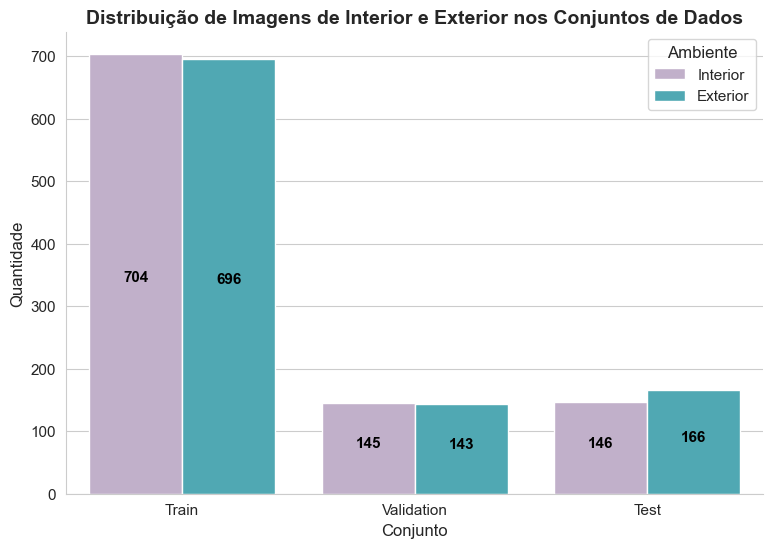

In [11]:
# Criar o gráfico
plt.figure(figsize=(9, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x="Dataset", y="Count", hue="Ambiente", data=df, palette=["#C3ACCE", "#3FB5C4"])

# Adicionar valores absolutos e percentuais nas barras
for t, p in enumerate(ax.patches[0:6]):
    height = p.get_height()

    x_pos = p.get_x() + p.get_width() / 2  # Posição horizontal central da barra

    dataset = 'Train' if x_pos < 0.5 else 'Validation' if 0.5 < x_pos < 1.5 else 'Test'

    ambiente = "Interior" if t % 2 == 0 else "Exterior"
    if dataset == 'Validation':
        ambiente = "Interior" if t % 2 == 1 else "Exterior"  # Corrige inversão, se necessário

    row = df[(df['Dataset'] == dataset) & (df['Ambiente'] == ambiente)].iloc[0]
    value = row['Count']
    percent = row['Percent']

    ax.annotate(f"{int(value)}",  # \n({percent:.1f}%)
                (x_pos, height / 2.1),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold', color='black')

# Melhorar visualização
plt.title("Distribuição de Imagens de Interior e Exterior nos Conjuntos de Dados", fontsize=14, fontweight='bold')
plt.xlabel("Conjunto", fontsize=12)
plt.ylabel("Quantidade", fontsize=12)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.legend(title="Ambiente", title_fontsize=12, fontsize=11)
sns.despine()

# Mostrar o gráfico
plt.show()

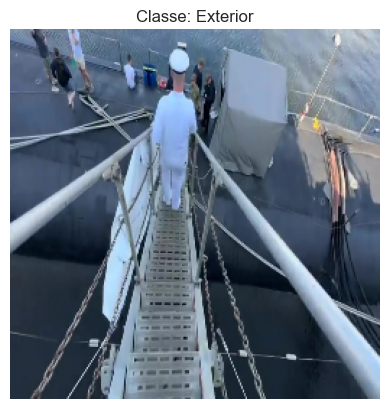

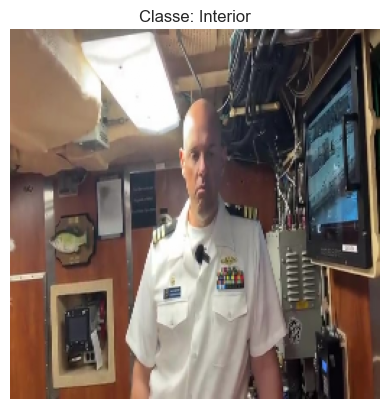

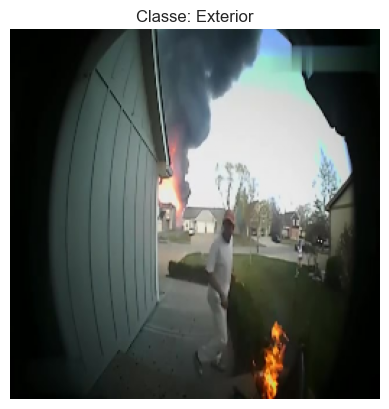

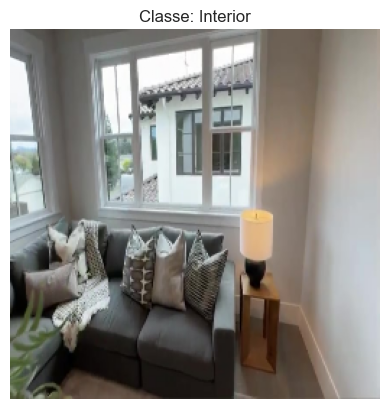

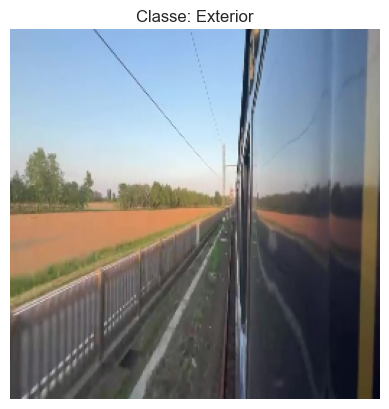

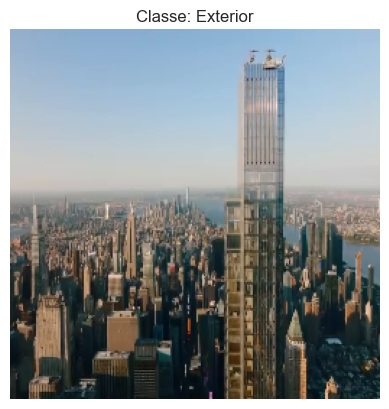

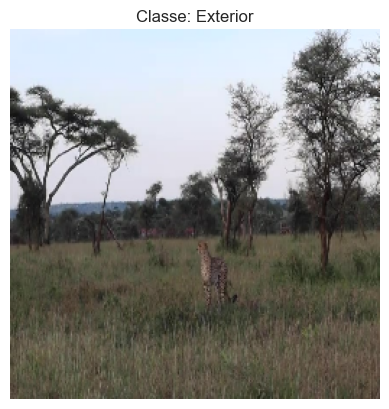

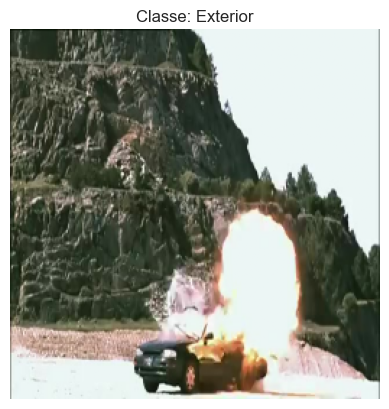

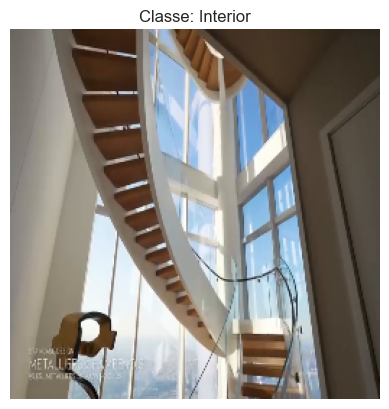

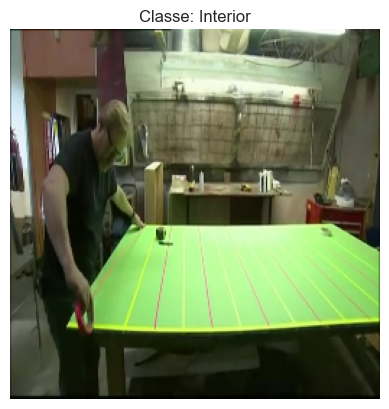

In [12]:
for batch_x, batch_y in train_ds:
    for i, x in enumerate(batch_x):
        if i >= 10:
            break
        x = np.asarray(x) / 255
        plt.imshow(x)
        plt.title(f'Classe: {labels[int(batch_y[i])]}')
        plt.axis('off')  # Esconder os eixos
        plt.show()
    break

## Rede Neuronal Conv

> Definir a rede

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05), 
    layers.RandomZoom(0.1),             
    layers.RandomTranslation(0.1, 0.1),   
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

# TODO: ajustar estes augments!!!!

In [24]:
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)), 
    #data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  
])

> Callbacks

In [25]:
best_model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=f"tmp/cnn_interior_exterior.weights.h5",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6
)

> Compile da rede

In [26]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

> Training

In [27]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[best_model_checkpoint, early_stopping, reduce_lr]
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 648ms/step - accuracy: 0.6024 - loss: 0.7784 - precision_2: 0.6212 - recall_2: 0.5891 - val_accuracy: 0.7153 - val_loss: 0.5647 - val_precision_2: 0.7607 - val_recall_2: 0.6224 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 29s 667ms/step - accuracy: 0.7627 - loss: 0.5227 - precision_2: 0.7965 - recall_2: 0.7168 - val_accuracy: 0.7118 - val_loss: 0.5512 - val_precision_2: 0.8750 - val_recall_2: 0.4895 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 693ms/step - accuracy: 0.7662 - loss: 0.4900 - precision_2: 0.8085 - recall_2: 0.7151 - val_accuracy: 0.7604 - val_loss: 0.4961 - val_precision_2: 0.8627 - val_recall_2: 0.6154 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 638ms/step - accuracy: 0.7925 - loss: 0.4262 - precision_2: 0.8380 - recall_2: 0.7377 - val_accuracy: 0.7778 - val_loss: 0.4740 - val_precision_2: 0.8110 - val_recall_2: 0.7203 - learning_rate: 0.0010
Epoch 5/50
44/44 ━━━━━━━━━━━

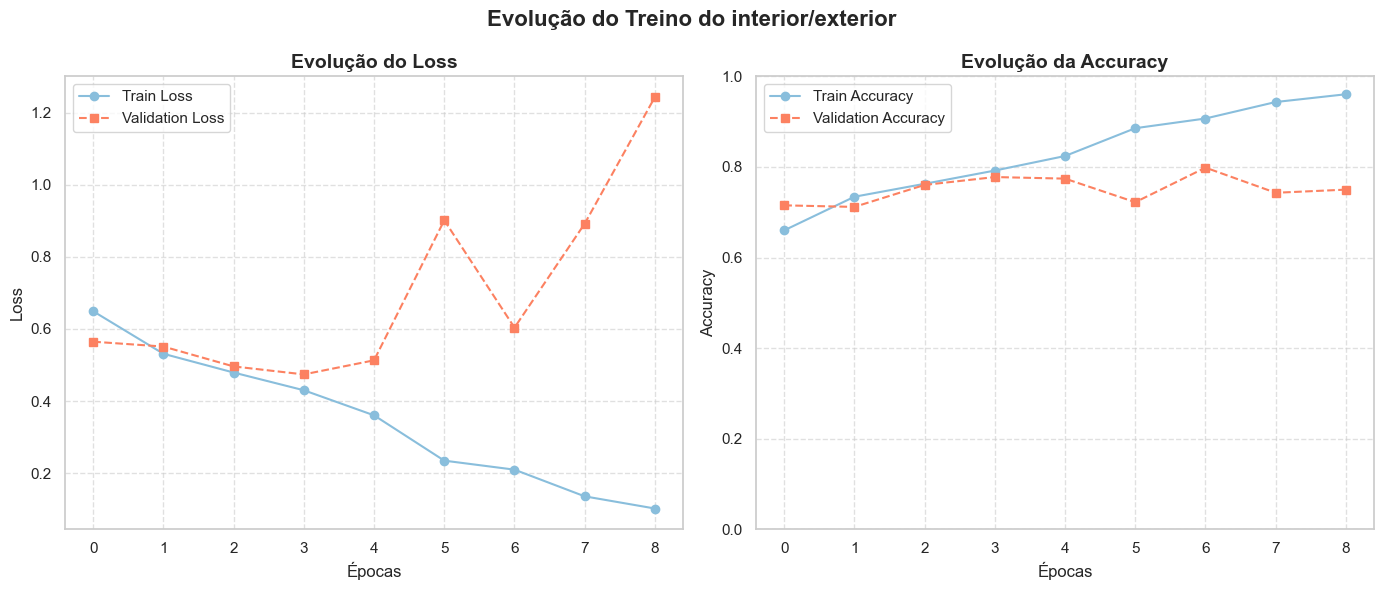

In [28]:
sns.set(style="whitegrid", palette="muted")

# Criar a figura
plt.figure(figsize=(14, 6))

# Subplot para Loss
plt.subplot(1, 2, 1)
# epochs = range(1, len(history.history['loss']))  # Garante que começa em 1
plt.plot(history.history['loss'], label='Train Loss', color=sns.color_palette("Blues")[2], linestyle='-', marker='o', markersize=6)
plt.plot(history.history['val_loss'], label='Validation Loss', color=sns.color_palette("Reds")[2], linestyle='--', marker='s', markersize=6)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Evolução do Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Definir os ticks do eixo X para começar em 1
#plt.xticks(epochs)

# Subplot para Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color=sns.color_palette("Blues")[2], linestyle='-', marker='o', markersize=6)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color=sns.color_palette("Reds")[2], linestyle='--', marker='s', markersize=6)
plt.xlabel('Épocas', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Evolução da Accuracy', fontsize=14, fontweight='bold')
plt.ylim(0, 1)  # Garantir que o eixo Y da Accuracy vai de 0 a 1
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Adicionar um título geral à figura
plt.suptitle(f'Evolução do Treino do interior/exterior', fontsize=16, fontweight='bold')

# Ajustar espaçamento
plt.tight_layout()
plt.show()


In [29]:
model.load_weights(f"tmp/cnn_interior_exterior.weights.h5")
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,517,317 (169.82 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,678,212 (113.21 MB)

## Conjunto de teste

In [30]:
train_list = list(train_ds)
first_batch_x, first_batch_y = train_list[0]
len(train_labels)

1400

In [31]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)[:2]
num_acertos = int(test_acc * len(test_labels))
print(f'Accuracy no conjunto de teste: {test_acc:.4f}')
print(f'Número absoluto de acertos: {num_acertos}/{len(test_labels)}')

Accuracy no conjunto de teste: 0.7564
Número absoluto de acertos: 235/312


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


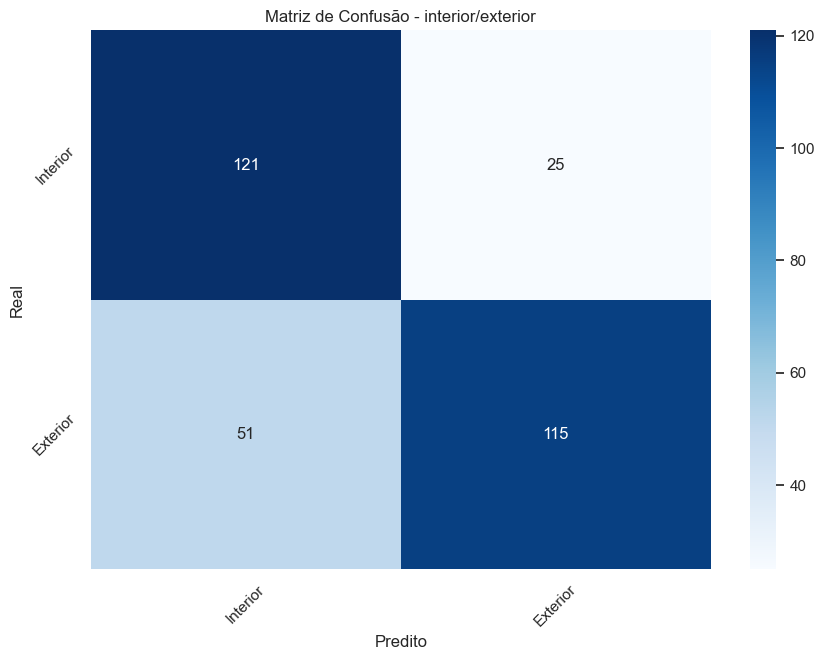

In [32]:
y_pred = model.predict(test_ds).squeeze()
y_pred_classes = y_pred>0.5
y_true_classes = test_labels.squeeze()

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - interior/exterior')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

## Model Explanation

In [33]:
linear_model = tf.keras.models.Model(inputs=[model.layers[0].input], outputs=[model.layers[-2].output])
train_preds = model.predict(train_ds).squeeze()
labels

44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step


['Interior', 'Exterior']

In [34]:
train_list = list(train_ds)
score = CategoricalScore([0])
saliency = Saliency(model, clone=False)

In [35]:
test_images = []
test_class = []
for batch_x, batch_y in test_ds:
    for image, class_ in zip(batch_x, batch_y):
        test_images.append(np.array(image))
        test_class.append(class_)
bad_preds = (y_pred_classes != y_true_classes).nonzero()[0]

C:\Users\35196\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_38
Received: inputs=['Tensor(shape=(1, 256, 256, 3))']
  warnings.warn(msg)


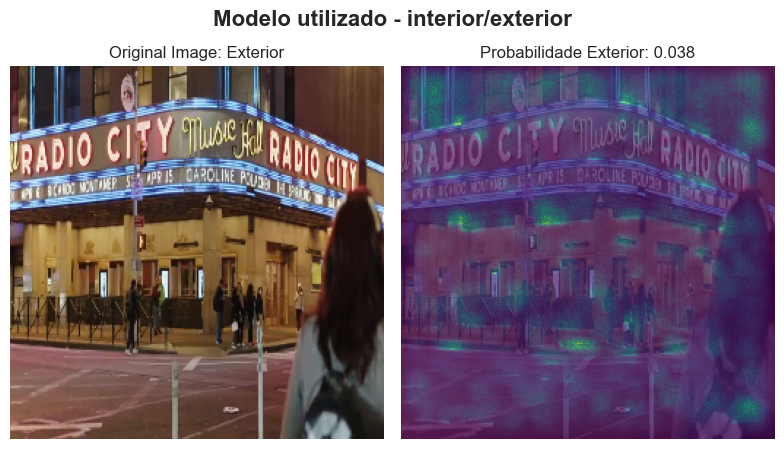

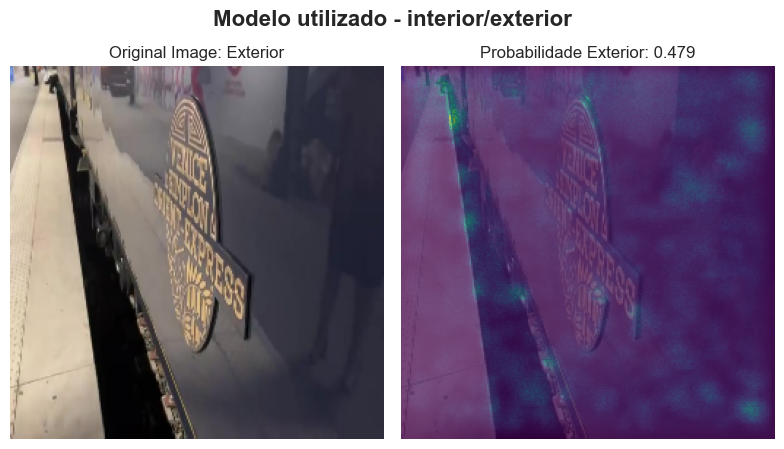

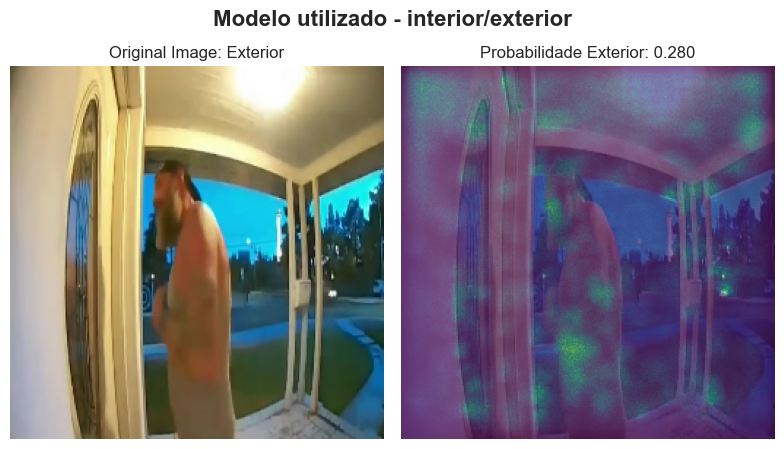

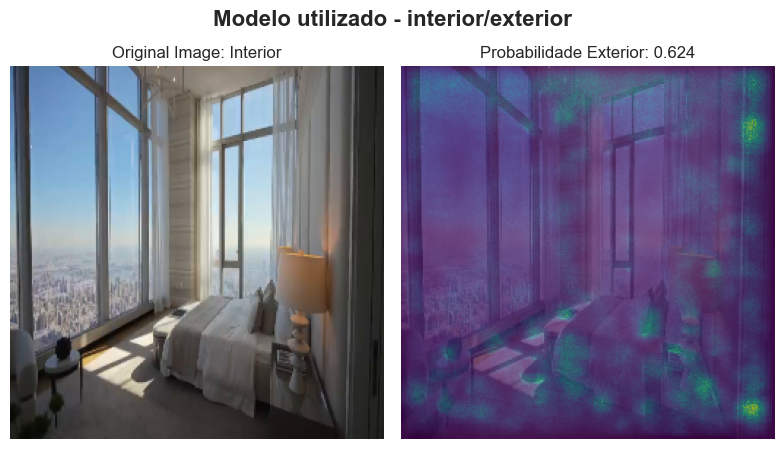

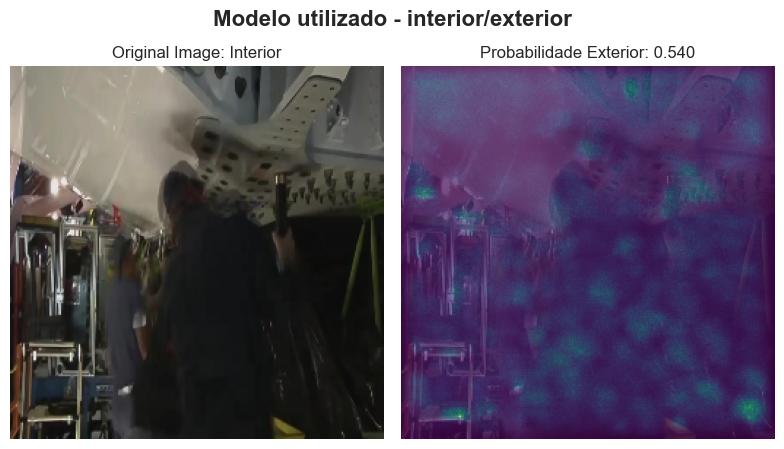

In [36]:
for img_id in bad_preds[:5]:
    # Load and preprocess an example image
    img = test_images[img_id]  # array
    img_array = np.expand_dims(img, axis = 0)  # Normalize and add batch dimension, now numpy array
    # Compute saliency map
    saliency_map = saliency(score, img_array, smooth_samples=20, smooth_noise=0.2, normalize_map=True)
    # saliency_map = normalize(saliency_map)
    # Overlay saliency map on original image
    heatmap = cv2.cvtColor(cv2.applyColorMap(np.uint8(np.floor(saliency_map*255)).squeeze(), cv2.COLORMAP_VIRIDIS), cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(heatmap, 0.7, np.uint8(img), 0.3, 0)
    
    # Display results
    fig, ax = plt.subplots(1, 2, figsize=(8, 3*1.75))
    ax[0].imshow(img/255)
    ax[0].set_title(f"Original Image: {labels[int(test_class[img_id])]}")
    ax[0].axis("off")
    
    ax[1].imshow(overlay)
    ax[1].set_title(f"Probabilidade {labels[1]}: {y_pred[img_id]:.3f}")
    ax[1].axis("off")
    
    # Adicionar um título geral à figura
    plt.suptitle(f'Modelo utilizado - interior/exterior', fontsize=16, fontweight='bold')
        
    plt.tight_layout()  # Ajusta o layout para evitar sobreposição
    plt.subplots_adjust(top=1)  # Ajusta o espaço para o título geral
    plt.show()